In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F  # Import functional API for Leaky ReLU
import torch.optim as optim

torch.manual_seed(42)

In [16]:
# Solve with Analytical Solution
# Solve with Numerical Method
# Solve with NN (Vary learning rate, activation function, architecture)
# Evaluate numerical method for different CFL numbers, see how the NN handles it

In [17]:
# Parameters
nx = 500  # Number of spatial grid points
L = 5.0  # Length of the domain
dt = 0.01  # Time step
a = 1.0  # Advection speed
T = 5.0  # Total simulation time
nt = int(T / dt)  # Number of time steps
dx = L / (nx - 1)  # Spatial resolution

# Grid points
x = np.linspace(0, L, nx)
t = np.linspace(0, T, int(T/dt))

CFL = a * dt / dx
print(f"CFL Number: {CFL}")

# Initial condition: Gaussian pulse
def initial_condition(x):
    return np.exp(-((x - L / 4) / 0.1) ** 2)

# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(2, 64)  # Input: (x, t)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)
        self.fc6 = nn.Linear(64, 1)  # Output: u(x, t)

    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)  # Concatenate x and t
        out = torch.sin(self.fc1(inputs))
        out = torch.sin(self.fc2(out))
        out = torch.sin(self.fc3(out))
        out = torch.sin(self.fc4(out))
        out = torch.sin(self.fc5(out))
        out = self.fc6(out)
        return out

# Initialize network and optimizer
model = NeuralNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define loss functions
def pde_loss(x, t, a):
    x.requires_grad_(True)
    t.requires_grad_(True)
    u = model(x, t)
    u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return torch.mean((u_t + a * u_x) ** 2)

def ic_loss(x):
    # Detach x and convert to NumPy for initial_condition
    x_np = x.detach().numpy()
    u_true = torch.tensor(initial_condition(x_np), dtype=torch.float32).reshape(-1, 1)
    u_pred = model(x, torch.zeros_like(x))  # Evaluate at t = 0
    return torch.mean((u_pred - u_true) ** 2)

def boundary_loss(t):
    # Sample points at the boundaries (x = 0 and x = L)
    x_left = torch.zeros_like(t)  # x = 0
    x_right = torch.full_like(t, L)  # x = L

    # Evaluate the model at the boundaries
    u_left = model(x_left, t)
    u_right = model(x_right, t)

    # Compute the mean squared error of the difference
    return torch.mean((u_left - u_right) ** 2)

# Training loop
for epoch in range(15000):
    optimizer.zero_grad()

    # Sample random collocation points
    num_samples = 250
    x_torch = torch.tensor(np.random.choice(x, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)
    t_torch = torch.tensor(np.random.choice(t, num_samples, replace=True), dtype=torch.float32).reshape(-1, 1)

    # Compute losses
    loss_pde = pde_loss(x_torch, t_torch, a)
    loss_ic = ic_loss(x_torch)
    loss_boundary = boundary_loss(t_torch)  # Add boundary loss
    loss = 2*loss_pde + loss_ic + loss_boundary  # Include boundary loss in total loss

    # Backpropagation
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}, PDE Loss: {loss_pde.item()}, IC Loss: {loss_ic.item()}, Boundary Loss: {loss_boundary.item()}")

CFL Number: 0.9980000000000001
Epoch 0, Loss: 0.08296765387058258, PDE Loss: 0.0022509621921926737, IC Loss: 0.06236977130174637, Boundary Loss: 0.0160959605127573
Epoch 1000, Loss: 0.0030660550110042095, PDE Loss: 0.00036575784906744957, IC Loss: 0.0017155566019937396, Boundary Loss: 0.0006189827108755708
Epoch 2000, Loss: 0.0010757317068055272, PDE Loss: 0.0002613025426398963, IC Loss: 0.0001789266534615308, Boundary Loss: 0.0003741999389603734
Epoch 3000, Loss: 0.0001943606766872108, PDE Loss: 5.6740394938969985e-05, IC Loss: 1.0885170013352763e-05, Boundary Loss: 6.999470497248694e-05
Epoch 4000, Loss: 0.00018327953875996172, PDE Loss: 2.47761417995207e-05, IC Loss: 3.3682514185784385e-05, Boundary Loss: 0.00010004473733715713
Epoch 5000, Loss: 0.00018587405793368816, PDE Loss: 2.5392802854184993e-05, IC Loss: 5.283999053062871e-05, Boundary Loss: 8.224845078075305e-05
Epoch 6000, Loss: 2.5897601517499425e-05, PDE Loss: 8.413263458351139e-06, IC Loss: 1.461694637328037e-06, Boundar

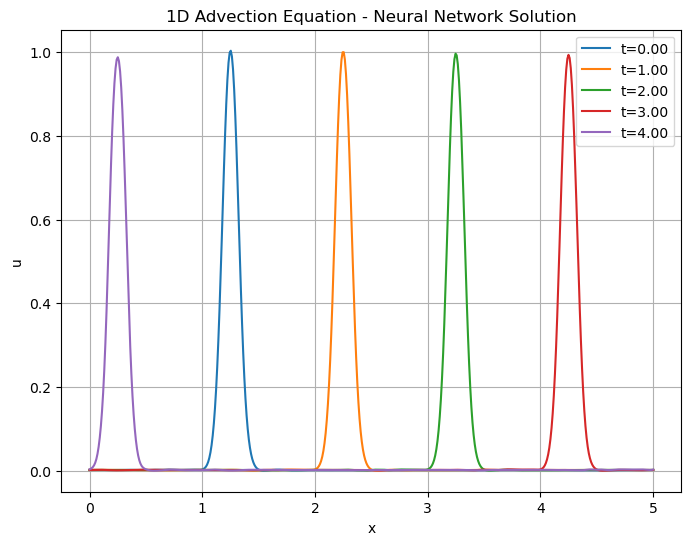

In [19]:
# Plot the results
plt.figure(figsize=(8, 6))
x_test = torch.tensor(x, dtype=torch.float32).reshape(-1, 1)

# Plot at specific time intervals
for n in range(5):
    t_test = torch.full_like(x_test, n) # Creates a vector with the same shape as x_test with a constant value equal to n
    with torch.no_grad(): 
        u_pred = model(x_test, t_test).detach().numpy()  # Detach tensor before converting to NumPy
    plt.plot(x, u_pred, label=f"t={n:.2f}")

plt.title('1D Advection Equation - Neural Network Solution')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.grid()
plt.savefig('plots/nn_1d.png')
plt.show()